In [1]:
#beginning code from https://www.kaggle.com/shanan93/brain-mri-segmentation-95-5-accuracy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import zipfile
import cv2
from skimage import io
from natsort import natsorted

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import os
import glob
import random
#%matplotlib inline

/Users/distantbeliefs/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
main_df = pd.read_csv('archive/lgg-mri-segmentation/kaggle_3m/data.csv')

In [3]:
data_map = []
for sub_dir_path in glob.glob("archive/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)


[Errno 20] Not a directory: 'archive/lgg-mri-segmentation/kaggle_3m/data.csv'
[Errno 20] Not a directory: 'archive/lgg-mri-segmentation/kaggle_3m/README.md'


In [4]:
df = pd.DataFrame({"path" : data_map[1::2]})
df.head()

,path
0,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
1,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
2,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
3,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
4,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...


In [5]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 
END_IMG_LEN = 4 
END_MASK_LEN = 9 

# Data sorting
imgs = natsorted(df_imgs["path"].values)
masks = natsorted(df_masks["path"].values)

In [6]:
# Final dataframe
brain_df = pd.DataFrame({"image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['label'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,image_path,mask_path,label
0,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
1,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
2,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
3,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
4,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,0
...,...,...,...
3924,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,0
3925,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,0
3926,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,0
3927,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,archive/lgg-mri-segmentation/kaggle_3m/TCGA_HT...,0


In [7]:
brain_df['label'].value_counts()

0    2556
1    1373
Name: label, dtype: int64

IndexError: index 6 is out of bounds for axis 0 with size 6

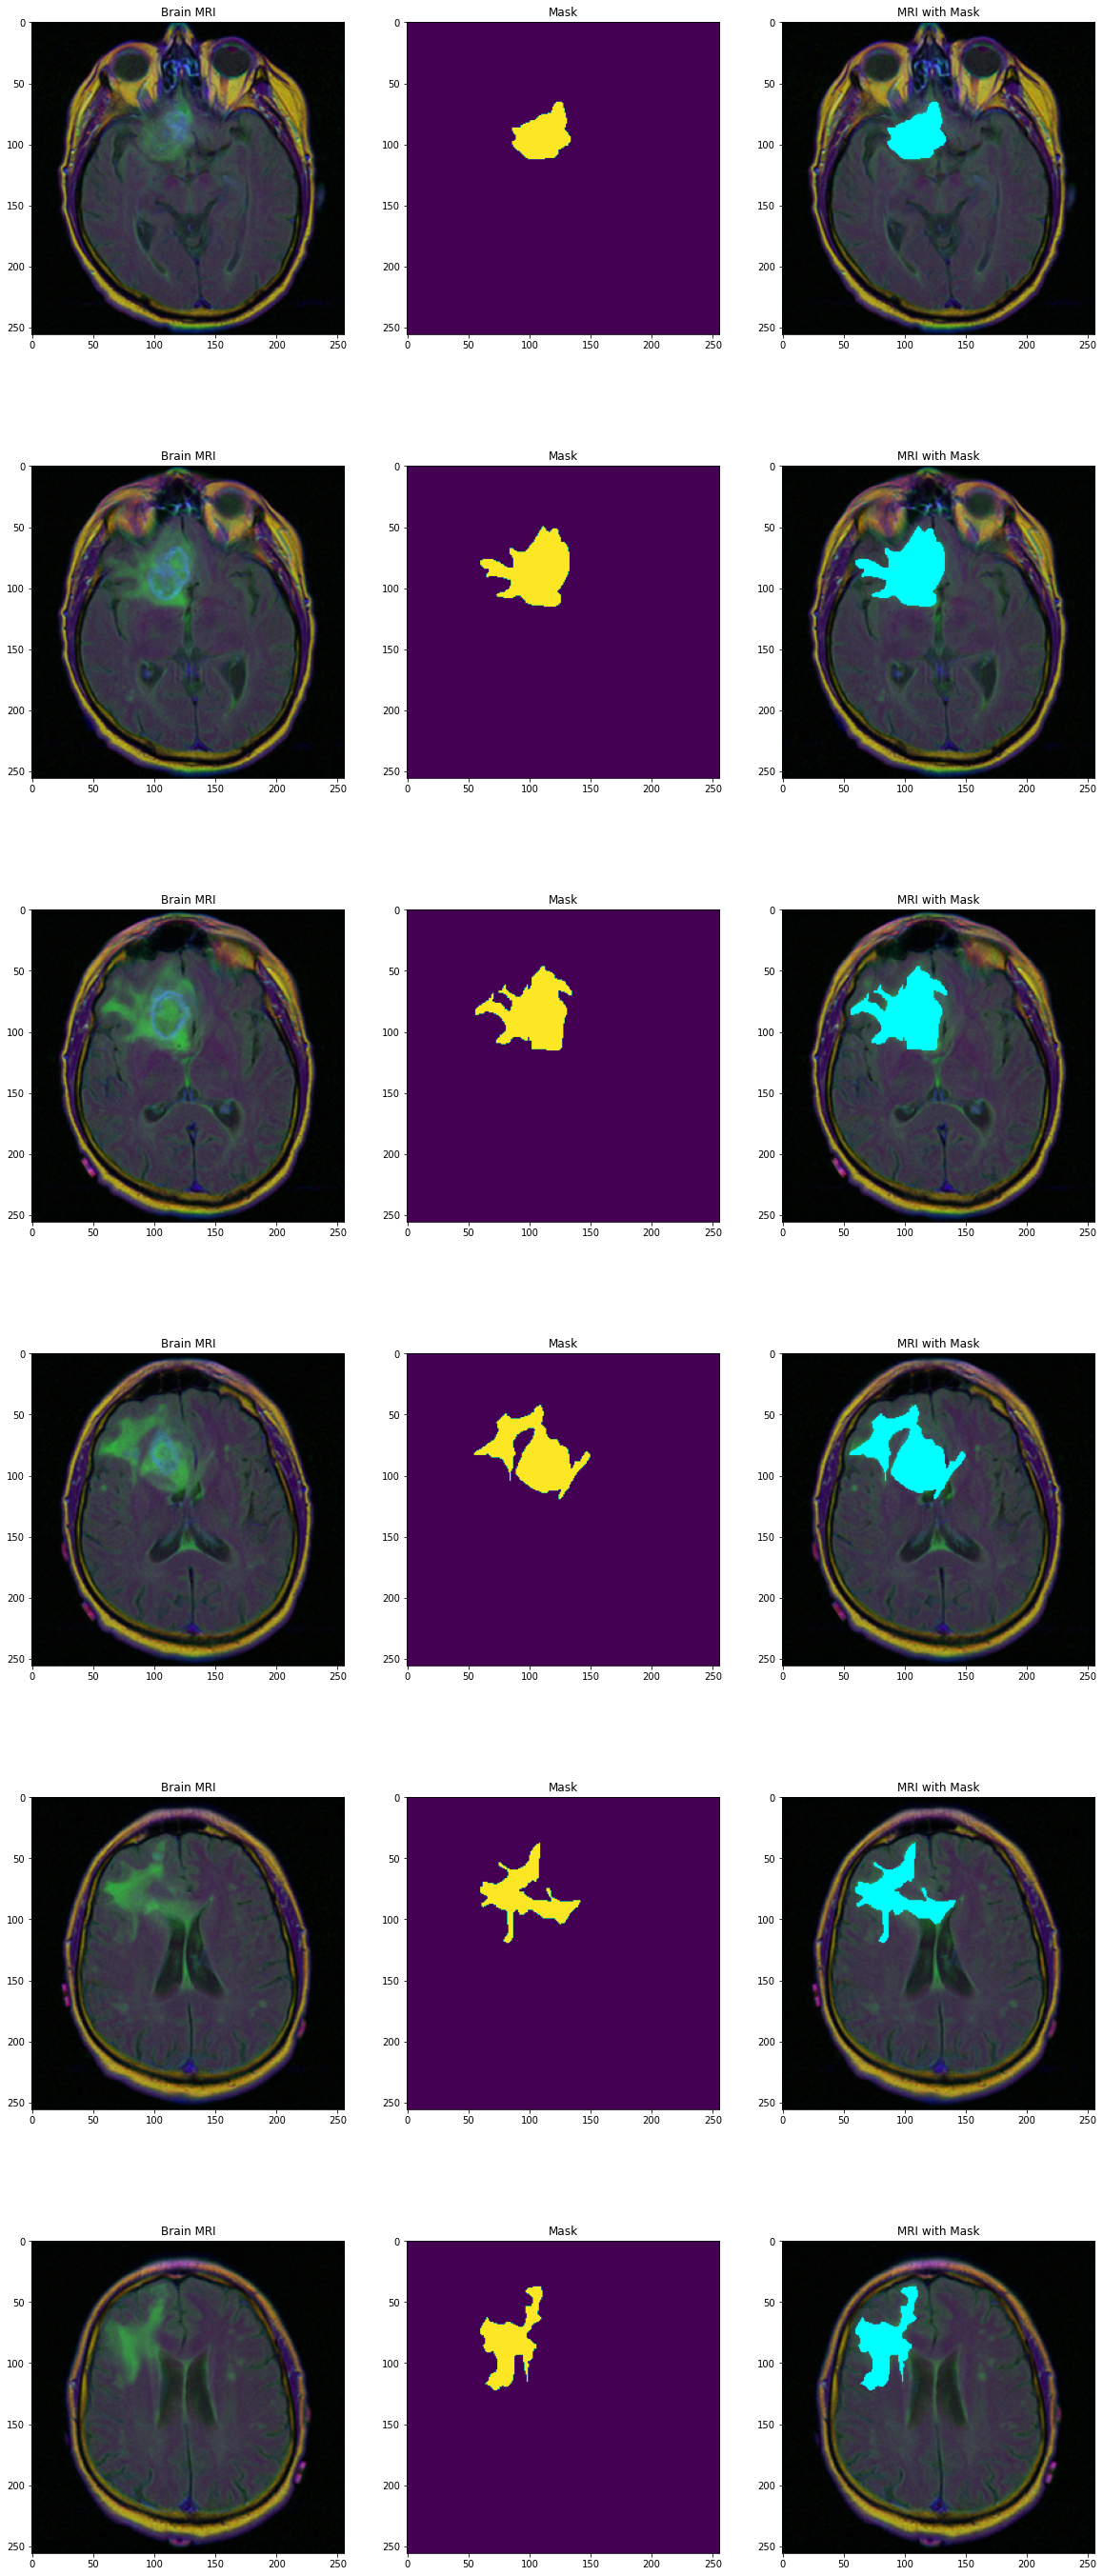

In [13]:
count = 0
fig, axs = plt.subplots(6, 3, figsize = (20,50))
for i in range(len(brain_df)):
    if brain_df['label'][i] ==1:
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text('Brain MRI')
        axs[count][0].imshow(img)

        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text('Mask')
        axs[count][1].imshow(mask)#, cmap = 'gray')


        img[mask==255] = (0, 255, 255)
        axs[count][2].title.set_text('MRI with Mask')
        axs[count][2].imshow(img)
        
        count+=1
fig.savefig('Brain_mri.png')
fig.tight_layout()


In [14]:
img = io.imread(brain_df.image_path[i])
img.shape


(256, 256, 3)

In [15]:
brain_df['label'] = brain_df['label'].apply(lambda x: str(x))
train, test = train_test_split(brain_df, test_size = 0.2)

In [16]:
idg = ImageDataGenerator(rescale=1/255, shear_range = 0.2, zoom_range = 0.2, validation_split = 0.2)
train_gen = idg.flow_from_dataframe(dataframe=train, directory= './', x_col='image_path', y_col='label', 
                                    subset="training",class_mode="categorical", target_size=(256, 256))

valid_gen = idg.flow_from_dataframe(dataframe=train, directory= './', x_col='image_path', y_col='label', 
                                   subset="validation", class_mode="categorical", target_size=(256, 256))

Found 2515 validated image filenames belonging to 2 classes.
Found 628 validated image filenames belonging to 2 classes.


In [17]:
from tensorflow.keras.backend import clear_session

In [18]:
clear_session()

In [20]:
test_idg = ImageDataGenerator(rescale=1/255, shear_range = 0.2, zoom_range = 0.2,)

test_gen = test_idg.flow_from_dataframe(dataframe=test, directory= './', x_col='image_path', y_col='label',
                                            class_mode='categorical', target_size=(256, 256))

Found 786 validated image filenames belonging to 2 classes.


In [21]:
model = Sequential([
    layers.Conv2D(128, 6, activation="relu", padding="same",input_shape=[256,256,3]),#input shape: [rows, columns, channels]
    layers.MaxPooling2D(4),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(4),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation="softmax")
])
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [88]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 128)     13952     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       65664     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       65664     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       131328    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       2

In [89]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
mc = ModelCheckpoint('best_model.h5')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(train_gen,
                    epochs=500,
                    validation_data = valid_gen, 
                    callbacks = [es, mc])
score = model.evaluate(valid_gen, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Epoch 1/500
79/79 [==============================] - 223s 3s/step - loss: 0.6623 - accuracy: 0.6474 - val_loss: 0.5733 - val_accuracy: 0.6513
Epoch 2/500
79/79 [==============================] - 208s 3s/step - loss: 0.5586 - accuracy: 0.6844 - val_loss: 0.4905 - val_accuracy: 0.7436
Epoch 3/500
79/79 [==============================] - 207s 3s/step - loss: 0.4707 - accuracy: 0.7421 - val_loss: 0.4629 - val_accuracy: 0.7564
Epoch 4/500
79/79 [==============================] - 207s 3s/step - loss: 0.4649 - accuracy: 0.7492 - val_loss: 0.4304 - val_accuracy: 0.7707
Epoch 5/500
79/79 [==============================] - 207s 3s/step - loss: 0.4312 - accuracy: 0.7826 - val_loss: 0.4349 - val_accuracy: 0.7596
Epoch 6/500
79/79 [==============================] - 207s 3s/step - loss: 0.4289 - accuracy: 0.7678 - val_loss: 0.4344 - val_accuracy: 0.7882
Epoch 7/500
79/79 [==============================] - 206s 3s/step - loss: 0.4212 - accuracy: 0.7815 - val_loss: 0.4657 - val_accuracy: 0.7930
Epoch 

In [ ]:
-lower size of images!
- maybe greyscale
- increase pooling size (4, or 6)!
- reducing filters (Conv2D ->64)

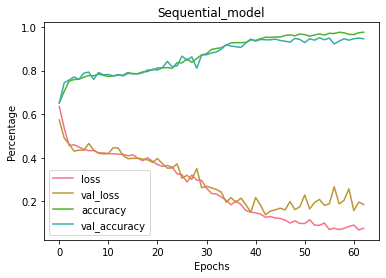

In [90]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.plot(history.history['accuracy'], label = 'accuracy');
plt.plot(history.history['val_accuracy'], label = 'val_accuracy');
plt.title("Sequential_model");
plt.ylabel("Percentage");
plt.xlabel("Epochs");
plt.legend()

plt.savefig('sequential_model')

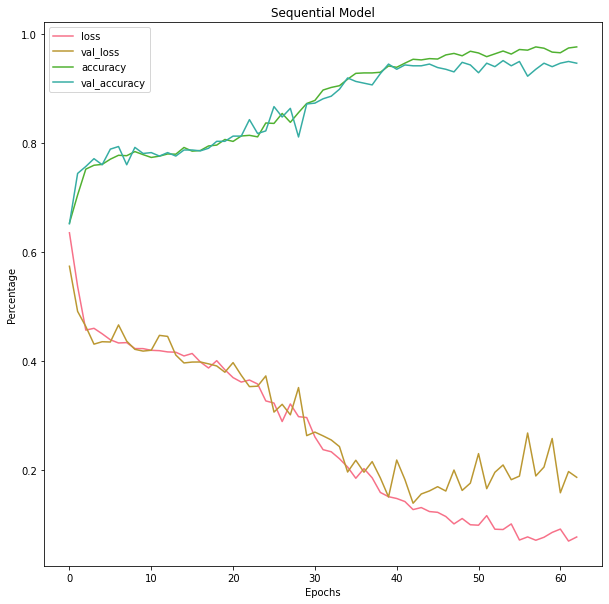

In [92]:
plt.figure(figsize=(10,10))
sns.set_palette("husl")
sns.lineplot(x = range(63), y = history.history['loss'], palette = palette, label = 'loss')
sns.lineplot(x = range(63), y = history.history['val_loss'], palette = palette, label = 'val_loss')
sns.lineplot(x = range(63), y = history.history['accuracy'], palette = palette, label = 'accuracy')
sns.lineplot(x = range(63), y = history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.title('Sequential Model')
plt.legend()
plt.show()

In [72]:
AlexNet = Sequential([
    layers.Conv2D(128, 6, activation="relu", padding="same", input_shape=[256,256,3]),#input shape: [rows, columns, channels]
    layers.MaxPooling2D(4),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(4),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation="softmax")
])
AlexNet.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [73]:
AlexNet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 256, 256, 128)     13952     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 128)       65664     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)       65664     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 256)       131328    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 256)      

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
mc = ModelCheckpoint('best_model.h5')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history1 = AlexNet.fit(train_gen,
                    epochs=500,
                    validation_data = valid_gen,
                    callbacks = [es,mc])
score = model.evaluate(valid_gen, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

NameError: name 'AlexNet' is not defined

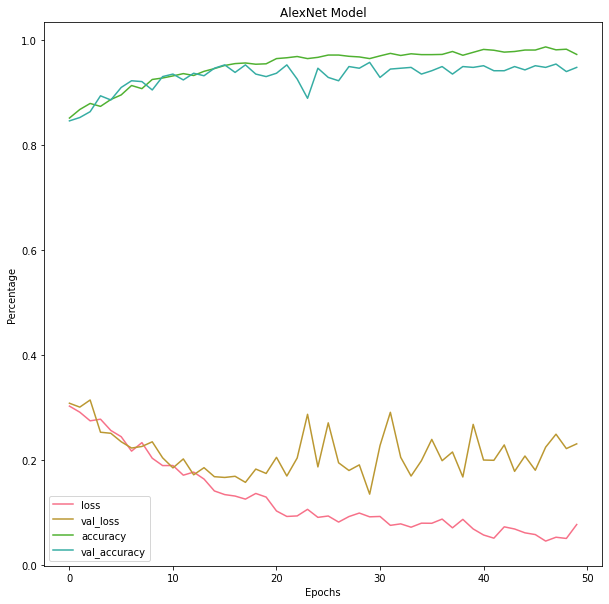

In [83]:
plt.figure(figsize=(10,10))
sns.set_palette("husl")
sns.lineplot(x = range(50), y = history1.history['loss'], palette = palette, label = 'loss')
sns.lineplot(x = range(50), y = history1.history['val_loss'], palette = palette, label = 'val_loss')
sns.lineplot(x = range(50), y = history1.history['accuracy'], palette = palette, label = 'accuracy')
sns.lineplot(x = range(50), y = history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.title('AlexNet Model')
plt.legend()
plt.show()

In [12]:
model = Sequential([
    layers.Conv2D(128, 6, activation="relu", padding="same",input_shape=[256,256,3]),#input shape: [rows, columns, channels]
    layers.MaxPooling2D(4),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.Conv2D(128, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(4),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.Conv2D(256, 2, activation="relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation="softmax")
])
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

NameError: name 'Sequential' is not defined

In [33]:
from d2l import tensorflow as d2l

class Inception(tf.keras.Model):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu', padding="same")
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu', padding="same")
        self.p2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same',
                                           activation='relu')
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu', padding="same")
        self.p3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same',
                                           activation='relu')
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
        self.p4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu', padding="same")

    def call(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # Concatenate the outputs on the channel dimension
        return layers.Concatenate()([p1, p2, p3, p4])

In [34]:
def b1():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=2, padding='same',input_shape=[256,256,3],
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])
def b2():
    return Sequential([
        layers.Conv2D(64, 1, activation='relu', padding="same"),
        layers.Conv2D(192, 3, padding='same', activation='relu'),
        layers.MaxPool2D(pool_size=3, strides=2, padding='same')])
def b3():
    return Sequential([
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        layers.MaxPool2D(pool_size=3, strides=2, padding='same')])
def b4():
    return Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        layers.MaxPool2D(pool_size=3, strides=2, padding='same')])
def b5():
    return Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        layers.GlobalAvgPool2D(),
        layers.Flatten()])

def net():
    return Sequential([
        b1(), b2(), b3(),
        b4(), b5(), layers.Dense(10), layers.Dense(2), layers.Activation('softmax')])

In [35]:
GoogleNet = net()
opt = optimizers.Adam(learning_rate=0.001)
GoogleNet.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

In [36]:
GoogleNet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 64)        9472      
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 192)       114944    
_________________________________________________________________
sequential_2 (Sequential)    (None, 16, 16, 480)       552432    
_________________________________________________________________
sequential_3 (Sequential)    (None, 8, 8, 832)         2809168   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1024)              2487536   
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
mc = ModelCheckpoint('Googs')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history2 = GoogleNet.fit(train_gen,
                    epochs=500,
                    validation_data = valid_gen,
                    callbacks = [es])#,mc])
score = GoogleNet.evaluate(valid_gen, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]) 

Epoch 1/500
79/79 [==============================] - 252s 3s/step - loss: 0.7166 - accuracy: 0.6390 - val_loss: 0.6579 - val_accuracy: 0.6401
Epoch 2/500
79/79 [==============================] - 246s 3s/step - loss: 0.6495 - accuracy: 0.6498 - val_loss: 0.6552 - val_accuracy: 0.6401
Epoch 3/500
79/79 [==============================] - 244s 3s/step - loss: 0.6369 - accuracy: 0.6577 - val_loss: 0.6248 - val_accuracy: 0.6401
Epoch 4/500
79/79 [==============================] - 246s 3s/step - loss: 0.5974 - accuracy: 0.6595 - val_loss: 0.6158 - val_accuracy: 0.6401
Epoch 5/500
79/79 [==============================] - 244s 3s/step - loss: 0.5969 - accuracy: 0.6545 - val_loss: 0.6115 - val_accuracy: 0.6401
Epoch 6/500
79/79 [==============================] - 243s 3s/step - loss: 0.5872 - accuracy: 0.6510 - val_loss: 0.5934 - val_accuracy: 0.6401
Epoch 7/500
79/79 [==============================] - 243s 3s/step - loss: 0.5812 - accuracy: 0.6650 - val_loss: 0.6054 - val_accuracy: 0.6401
Epoch 

In [32]:
clear_session()